## Changes in proportions of spots covered by the identified organs and tissues across stages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
import os
import sys

import warnings
warnings.filterwarnings("ignore")

### Load results

In [2]:
res_path = "Results/INSPIRE_developmental_stages"
adata = sc.read_h5ad(res_path + "/adata_inspire.h5ad")

annotations = ["Cartilage and connective tissue", "Brain region I", "Cavisity",
               "Other", "Meninges", "Jaw and tooth", "Liver", "Epidermis",
               "Muscle", "Brain region II", "Heart", "Lung", "Dorsal root ganglion",
               "Brain region III", "Olfactory epithelium and inner ear", "Sympathetic nerve"]

adata.obs["annotation"] = ""
for i in range(len(annotations)):
    adata.obs["annotation"][adata.obs["louvain"].values.astype(str) == str(i)] = annotations[i]

anno_list = list(sorted(["Cartilage and connective tissue", "Brain region I", "Cavisity",
                         "Meninges", "Jaw and tooth", "Liver", "Epidermis",
                         "Muscle", "Brain region II", "Heart", "Lung", "Dorsal root ganglion",
                         "Brain region III", "Olfactory epithelium and inner ear", "Sympathetic nerve"])) + ["Other"]
adata.obs["anno_num"] = 0
for i, anno in enumerate(anno_list):
    adata.obs["anno_num"][adata.obs["annotation"].values.astype(str) == anno] = i

rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb_dark2 = [i for i in get_cmap('Dark2').colors]
rgb_pst1 = [i for i in get_cmap('Pastel1').colors]
rgb_acc = [i for i in get_cmap('Accent').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex_dark2 = [mpl.colors.rgb2hex(color) for color in rgb_dark2]
rgb2hex_pst1 = [mpl.colors.rgb2hex(color) for color in rgb_pst1]
rgb2hex_acc = [mpl.colors.rgb2hex(color) for color in rgb_acc]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new + rgb2hex_dark2 + rgb2hex_pst1 + rgb2hex_acc

adata.obs["c_hex"] = ""
for i in range(len(annotations)):
    adata.obs["c_hex"][adata.obs["louvain"].values.astype(str) == str(i)] = rgb2hex[i]

In [3]:
n_slices = len(set(adata.obs["slice_label"]))
adata_list = []
for i in range(n_slices):
    adata_slice = adata[adata.obs.slice_label.values.astype(str) == str(i), :].copy()
    adata_list.append(adata_slice)

### Visualized the proportions of the embryo occupied by different spatial regions

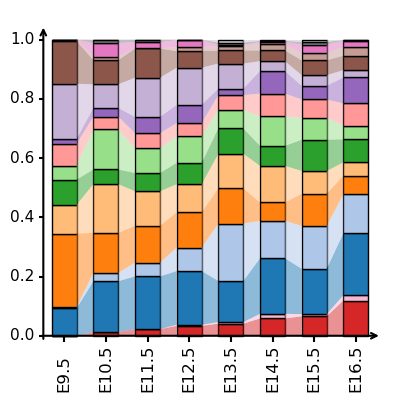

In [4]:
bottom = np.zeros(8)

fig, ax = plt.subplots(figsize=(5,5))

width = 0.6
for j in [6,13,0,1,2,3,4,5,7,8,9,10,11,12,14,15]:
    cl = str(j)
    num_bins = []
    prop_bins = []
    
    for i in range(n_slices):
        num_bins.append(np.sum(adata_list[i].obs["louvain"].values.astype(str) == cl))
        prop_bins.append(np.sum(adata_list[i].obs["louvain"].values.astype(str) == cl)/adata_list[i].shape[0])
    
    ax.bar(np.arange(8), prop_bins[::-1], color=adata[adata.obs["louvain"].values.astype(str) == cl, :].obs["c_hex"][0], 
           bottom=bottom, edgecolor='black', width=width)
    bottom = bottom + prop_bins[::-1]


for i in [7,6,5,4,3,2,1]:
    bottom = np.zeros(2)
    for j in [6,13,0,1,2,3,4,5,7,8,9,10,11,12,14,15]:
        cl = str(j)
        prop_bins = []
        prop_bins.append(np.sum(adata_list[i].obs["louvain"].values.astype(str) == cl)/adata_list[i].shape[0])
        prop_bins.append(np.sum(adata_list[i-1].obs["louvain"].values.astype(str) == cl)/adata_list[i-1].shape[0])
        real_i = 7 - i
        x = [real_i+width/2, real_i+width/2, real_i+1-width/2, real_i+1-width/2]
        y = [bottom[0], bottom[0]+prop_bins[0], bottom[1]+prop_bins[1], bottom[1]]
        plt.fill(x, y, facecolor=adata[adata.obs["louvain"].values.astype(str) == cl, :].obs["c_hex"][0], edgecolor="none", alpha=0.5)
        bottom = bottom + prop_bins   

slice_name_list = ["E16.5_E1S1", "E15.5_E1S2", "E14.5_E1S1", "E13.5_E1S3",
                   "E12.5_E1S1", "E11.5_E1S1", "E10.5_E2S1", "E9.5_E1S1"]
ax.annotate("", xy=(7+width+0.02, 0), xytext=(-width, 0), arrowprops=dict(arrowstyle="->", lw=1.5))
for i in range(n_slices):
    x_m = 7 - i
    plt.vlines(x = x_m, ymin=0, ymax=-.02, color = 'k')
    e_val = slice_name_list[i].split("_")[0]
    plt.annotate(e_val, xy=(x_m, -0.18), ha='center', fontsize=12, rotation=90)

ax.annotate("", xy=(-0.2-width/2, 1.05), xytext=(-0.2-width/2, -0.02), arrowprops=dict(arrowstyle="->", lw=1.5))
for y_val in [0.0,0.2,0.4,0.6,0.8,1.0]:
    plt.hlines(y = y_val, xmin=-0.3-width/2, xmax=-0.2-width/2, color = 'k')
    plt.annotate(y_val, xy=(-0.7-width/2, y_val-0.015), ha='center', fontsize=11)


plt.xlim(-1.3,8)
plt.ylim(-0.2,1.1)
ax.set_axis_off()
plt.show()